## How Neural Network sees a Cat

A neural network pre-trained on ImageNet is capable of recognizing any of 1000 different classes of objects, such as cats of different breeds. It would be interesting to see, what does the **ideal siamese cat** looks like for a neural network.

> Of course, you can replace *siamese cat* with any other ImageNet class.

To start, let's load VGG network:  

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from PIL import Image
import json
np.set_printoptions(precision=3,suppress=True)

model = keras.applications.VGG16(weights='imagenet',include_top=True)
classes = json.loads(open('imagenet_classes.json','r').read())

2022-06-17 13:28:58.931467: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-17 13:28:59.603736: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15401 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 6.0


## Optimizing for Result

To visualize the ideal cat, we will start with a random noise image, and will try to use the gradient descent optimization technique to adjust the image to make a network recognize a cat.

![Optimization Loop](images/ideal-cat-loop.png)

Here is our starting image:

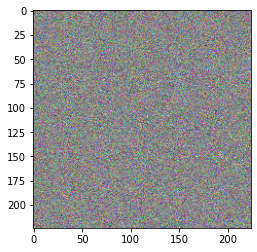

In [2]:
x = tf.Variable(tf.random.normal((1,224,224,3)))

def normalize(img):
    return (img-tf.reduce_min(img))/(tf.reduce_max(img)-tf.reduce_min(img))

plt.imshow(normalize(x[0]))

> We use `normalize` function to bring our values into 0-1 range.

If we call our VGG network on this image, we will get more or less random distribution of probabilities:

2022-06-17 13:29:02.100818: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-06-17 13:29:02.570980: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Predicted class: 669 (mosquito net)
Probability of predicted class = 0.05466596782207489


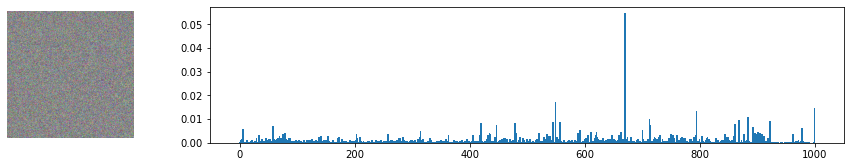

In [3]:
def plot_result(x):
    res = model(x)[0]
    cls = tf.argmax(res)
    print(f"Predicted class: {cls} ({classes[cls]})")
    print(f"Probability of predicted class = {res[cls]}")
    fig,ax = plt.subplots(1,2,figsize=(15,2.5),gridspec_kw = { "width_ratios" : [1,5]} )
    ax[0].imshow(normalize(x[0]))
    ax[0].axis('off')
    ax[1].bar(range(1000),res,width=3)
    plt.show()

plot_result(x)

> Even though it may look like the probability of one of the classes is much higher than the others, it is still very low - look at the scale to see that actual probability is still around 5%.

Now let's chose one target category (eg., **siamese cat**), and start adjusting the image using gradient descent. If $x$ is the input image, and $V$ is the VGG network, we will calculate the loss function $\mathcal{L} = \mathcal{L}(c,V(x))$ (where $c$ is the target category), and adjust $x$ using the following formula:
$$
x^{(i+1)} = x^{(i)} - \eta{\partial \mathcal{L}\over\partial x}
$$
Loss function would be cross-entropy loss, because we are comparing two probability distributions. In our case, because the class is represented by a number, and not by one-hot encoded vector, we will use *sparse categorical cross-entropy*.

We will repeat this process for several epochs, printing the image as we go.

> It is better to execute this code on GPU-enabled compute, or reduce the number of epochs in order to minimize waiting time.

Epoch: 900, loss: 0.5220473408699036


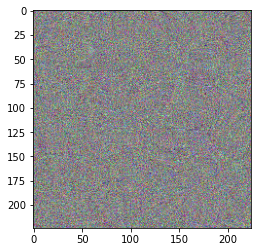

In [4]:
target = [284] # Siamese cat

def cross_entropy_loss(target,res):
    return tf.reduce_mean(keras.metrics.sparse_categorical_crossentropy(target,res))

def optimize(x,target,epochs=1000,show_every=None,loss_fn=cross_entropy_loss, eta=1.0):
    if show_every is None:
        show_every = epochs // 10
    for i in range(epochs):
        with tf.GradientTape() as t:
            res = model(x)
            loss = loss_fn(target,res)
            grads = t.gradient(loss,x)
            x.assign_sub(eta*grads)
            if i%show_every == 0:
                clear_output(wait=True)
                print(f"Epoch: {i}, loss: {loss}")
                plt.imshow(normalize(x[0]))
                plt.show()

optimize(x,target)

Predicted class: 284 (Siamese cat, Siamese)
Probability of predicted class = 0.6449142098426819


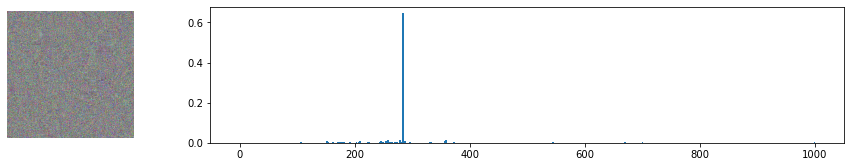

In [5]:
plot_result(x)

We now have obtained an image that looks like a cat for a neural network, even though it still looks like a noise for us. If we optimize for a little bit longer - we are likeley to get the image of **ideal noisy cat**, which has probability close to 1.

## Making Sense of Noise

This noise does not make a lot of sense for us, but most probably it contains a lot of low-level filters that are typical for a cat. However, because there are very many ways to optimize input for the ideal result, the optimization algorithm is not motivated to find patterns that are visually comprehensible.

To make this look a little bit less like a noise, we can introduce an additional term to the loss function - **variation loss**. It measures how similar neighboring pixels of the image are. If we add this term to our *loss function*, it will force the optimizer to find solutions with less noise, and thus having more recognizable details.

> In practice, we need to balance between cross-entropy loss and variation loss to obtain good results. In our function, we introduce some numeric coefficients, and you can play with them and observe how image changes.

Epoch: 900, loss: [27.257]


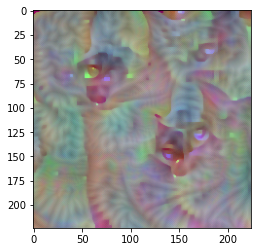

In [6]:
def total_loss(target,res):
    return 10*tf.reduce_mean(keras.metrics.sparse_categorical_crossentropy(target,res)) + \
           0.005*tf.image.total_variation(x,res)

optimize(x,target,loss_fn=total_loss)

This is the ideal image of a cat for our neural network, and we can also see some of the familiar features, such as eyes and ears. There are many of them, which makes neural network even more certain that this is a cat.

Predicted class: 284 (Siamese cat, Siamese)
Probability of predicted class = 0.9201651215553284


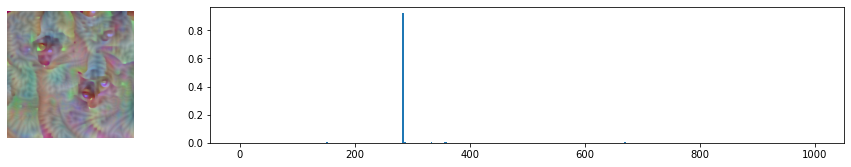

In [7]:
plot_result(x)

Let's also see how some other object looks like for the VGG:

Epoch: 900, loss: [29.59]


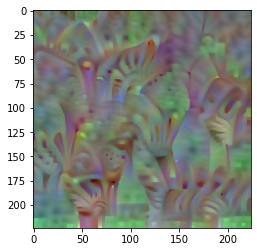

In [8]:
x = tf.Variable(tf.random.normal((1,224,224,3)))
optimize(x,[340],loss_fn=total_loss) # zebra

## Adversarial Attacks

Since *ideal cat* image can look like a random noise, it suggests that we can maybe tweak any image in a little way so that it changes it's class. Let's experiment with this a little bit. We will start with an image of a dog:

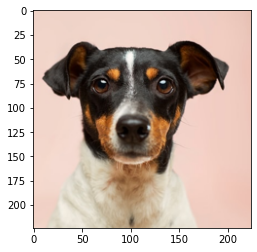

In [9]:
img = Image.open('images/dog-from-unsplash.jpg')
img = img.crop((200,20,600,420)).resize((224,224))
img = np.array(img)
plt.imshow(img)

We can see that this image is clearly recognized as a dog:

Predicted class: 171 (Italian greyhound)
Probability of predicted class = 0.9281901121139526


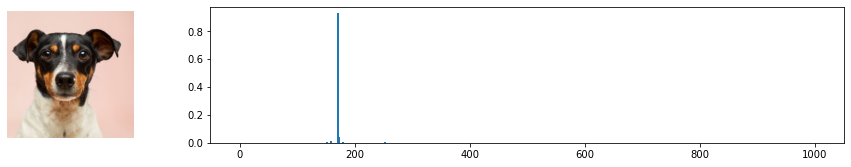

In [10]:
plot_result(np.expand_dims(img,axis=0))

Now, we will use this image a starting point, and try to optimize it to become a cat:

Epoch: 90, loss: 0.15769274532794952


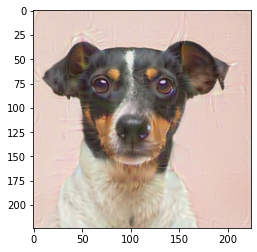

In [11]:
x = tf.Variable(np.expand_dims(img,axis=0).astype(np.float32)/255.0)
optimize(x,target,epochs=100)

Predicted class: 284 (Siamese cat, Siamese)
Probability of predicted class = 0.8651191592216492


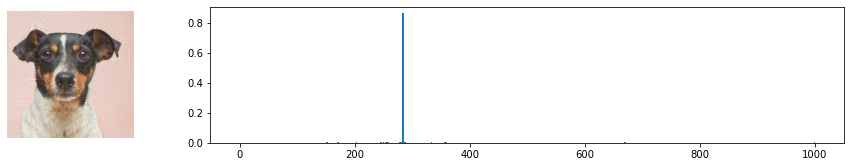

In [12]:
plot_result(x)

So, this image above is a perfect cat, from the point of view of VGG network!

## Experimenting with ResNet

Let's now see how this same image is classified by a different model, say, ResNet:

In [13]:
model = keras.applications.ResNet50(weights='imagenet',include_top=True)

> Since we used `model` as a global variable, from now on all functions will use ResNet instead of VGG

Predicted class: 111 (nematode, nematode worm, roundworm)
Probability of predicted class = 0.13089127838611603


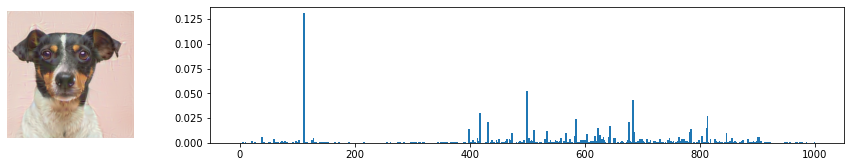

In [14]:
plot_result(x)

Apparenlty, the result is quite different. This is quite expected, because when optimizing for a cat we took into account the nature of VGG network, it's low-level filters, etc. Since ResNet has different filters, it gives different results. This gives us the idea of how we can protect ourselves from adversarial attacks - by using ensemble of different models.

Let's see how the ideal zebra looks like for ResNet:

Epoch: 450, loss: [46.166]


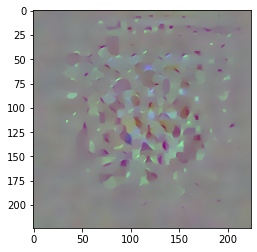

In [15]:
x = tf.Variable(tf.random.normal((1,224,224,3)))
optimize(x,target=[340],epochs=500,loss_fn=total_loss)

Predicted class: 340 (zebra)
Probability of predicted class = 0.8876020312309265


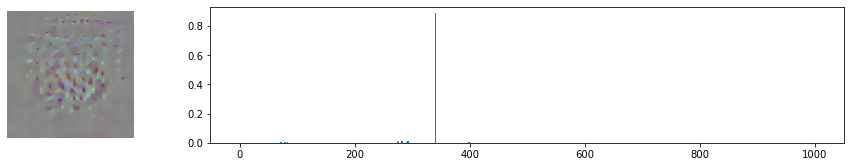

In [16]:
plot_result(x)

This picture is quite different, which tells us that the architecture of a neural network probably plays quite an important role in the way it recognizes objects.

> **Task**: Try to perform adversarial attach on ResNet, and compare the results.

## Using Different Optimizers

In our example, we have been using the simplest optimization technique - gradient descent. However, Keras framework contains different built-in [optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers), and we can use them instead of gradient descent. This will require very little change to our code - we will replace the part where we adjust input image `x.assign_sub(eta*grads)` with a call to `apply_gradients` function of the optimizer:

Epoch: 900, loss: [41.451]


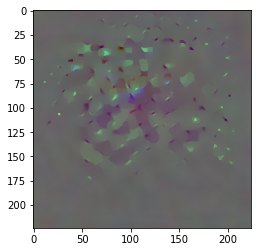

In [17]:
def optimize(x,target,epochs=1000,show_every=None,loss_fn=cross_entropy_loss,optimizer=keras.optimizers.SGD(learning_rate=1)):
    if show_every is None:
        show_every = epochs // 10
    for i in range(epochs):
        with tf.GradientTape() as t:
            res = model(x)
            loss = loss_fn(target,res)
            grads = t.gradient(loss,x)
            optimizer.apply_gradients([(grads,x)])
            if i%show_every == 0:
                clear_output(wait=True)
                print(f"Epoch: {i}, loss: {loss}")
                plt.imshow(normalize(x[0]))
                plt.show()

x = tf.Variable(tf.random.normal((1,224,224,3)))

optimize(x,[898],loss_fn=total_loss) # water bottle

## Conclusion

We were able to visualize the ideal image of a cat (as well as any other objects) within pre-trained CNN, using gradient descent optimization to adjust the input image instead of weights. The main trick to get the image that makes some sense was to use variation loss as an additional loss function, which enforces the image to look smoother. 